In [88]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from utils import find_clusters, plot_distribution_cluster
import warnings
import pickle
warnings.filterwarnings('ignore')

## Data Exploration

In [115]:
df = pd.read_csv('./Datasets/social_raw.csv')
print(df.shape)
print('\nLabel typed'); print(df.dtypes)
print('\nNull values:'); print(df.isnull().sum())

(1000, 12)

Label typed
age              int64
gender          object
time_spent       int64
platform        object
interests       object
location        object
demographics    object
profession      object
income           int64
indebt            bool
isHomeOwner       bool
Owns_Car          bool
dtype: object

Null values:
age             0
gender          0
time_spent      0
platform        0
interests       0
location        0
demographics    0
profession      0
income          0
indebt          0
isHomeOwner     0
Owns_Car        0
dtype: int64


### Description
The description for each column is as follows:

1. **age**: The age of the user.
2. **gender**: The gender identity of the user (Male, Female, Non-binary).
3. **time_spent**: Amount of time spent on Social Media by the user
4. **platform**: The social media platform where the user spends time.
5. **interests**: The user's primary area of interest or hobby.
6. **location**: The country of residence for the user. 
7. **demographics**: The type of area the user resides in (Urban, Suburban, Rural).
8. **profession**: The user's occupation or professional status.
9. **income**: The yearly income of the user.
10. **indebt**: Indicates whether the user is in debt (True or False).
11. **isHomeOwner**: Indicates whether the user owns a home (True or False).
12. **Owns_Car**: Indicates whether the user owns cars (True or False).

In [119]:
# Separare colonne numeriche e categoriche
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
categorical_columns = df.select_dtypes(include=['object', 'bool'])

# Codifica delle colonne categoriche
categorical_columns_encoded = pd.get_dummies(categorical_columns)

# Unisci i DataFrame numerici e codificati
df_combined = pd.concat([numeric_columns, categorical_columns_encoded], axis=1)

# Calcola la matrice di correlazione
correlation_matrix = df_combined.corr()


<Axes: >

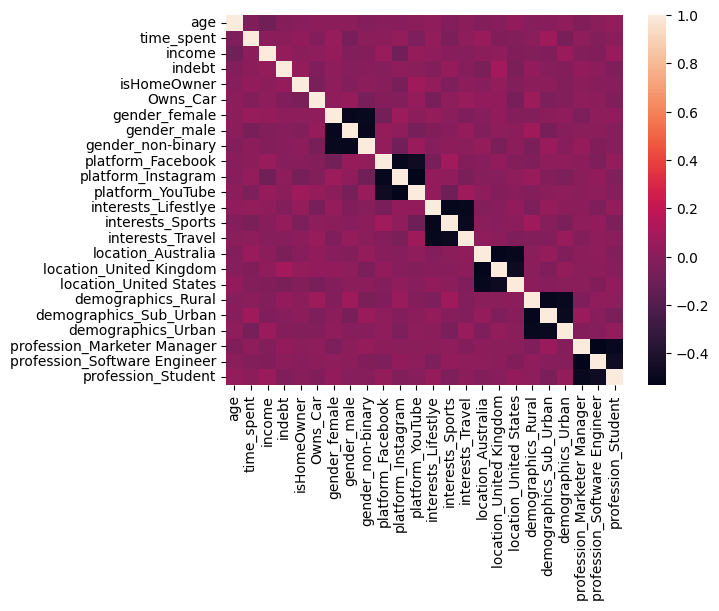

In [120]:
sns.heatmap(correlation_matrix)

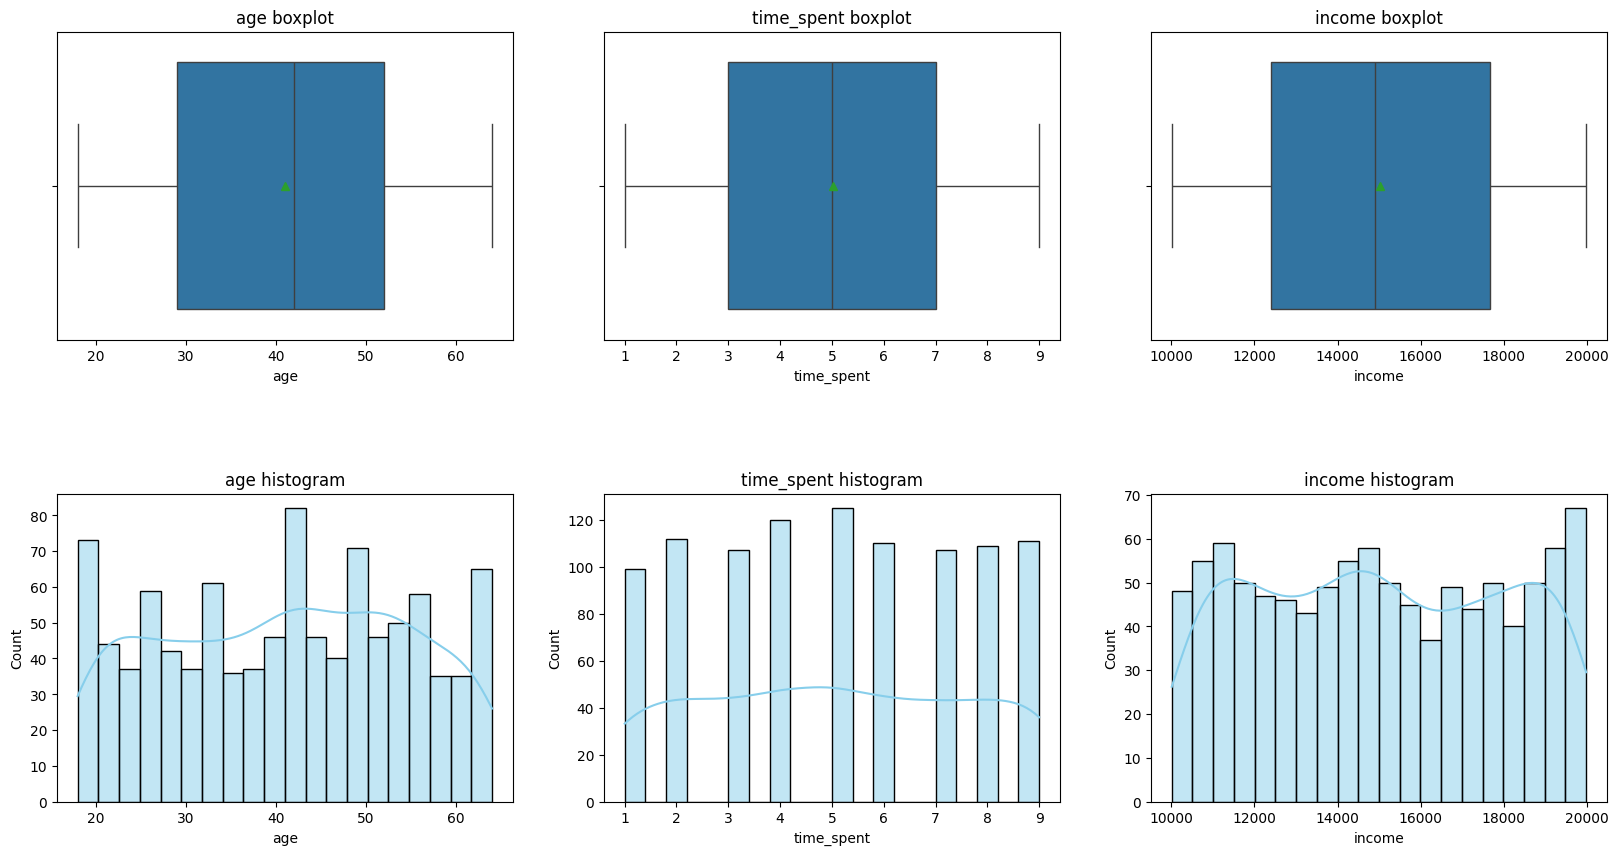

In [90]:
# Analysis of numerical attributes

from pandas import Int64Dtype


plt.figure(figsize=(20, 10))

i = 1
for attribute in df.columns :
    if str(df[attribute].dtype) == 'int64' :
        plt.subplot(2, 3, i)
        sns.boxplot(data=df, x=attribute, showfliers=True, showmeans=True)
        plt.title(f'{attribute} boxplot')

        plt.subplot(2, 3, i+3)
        sns.histplot(df[attribute], bins=20, kde=True, color='skyblue')
        plt.title(f'{attribute} histogram')

        i += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

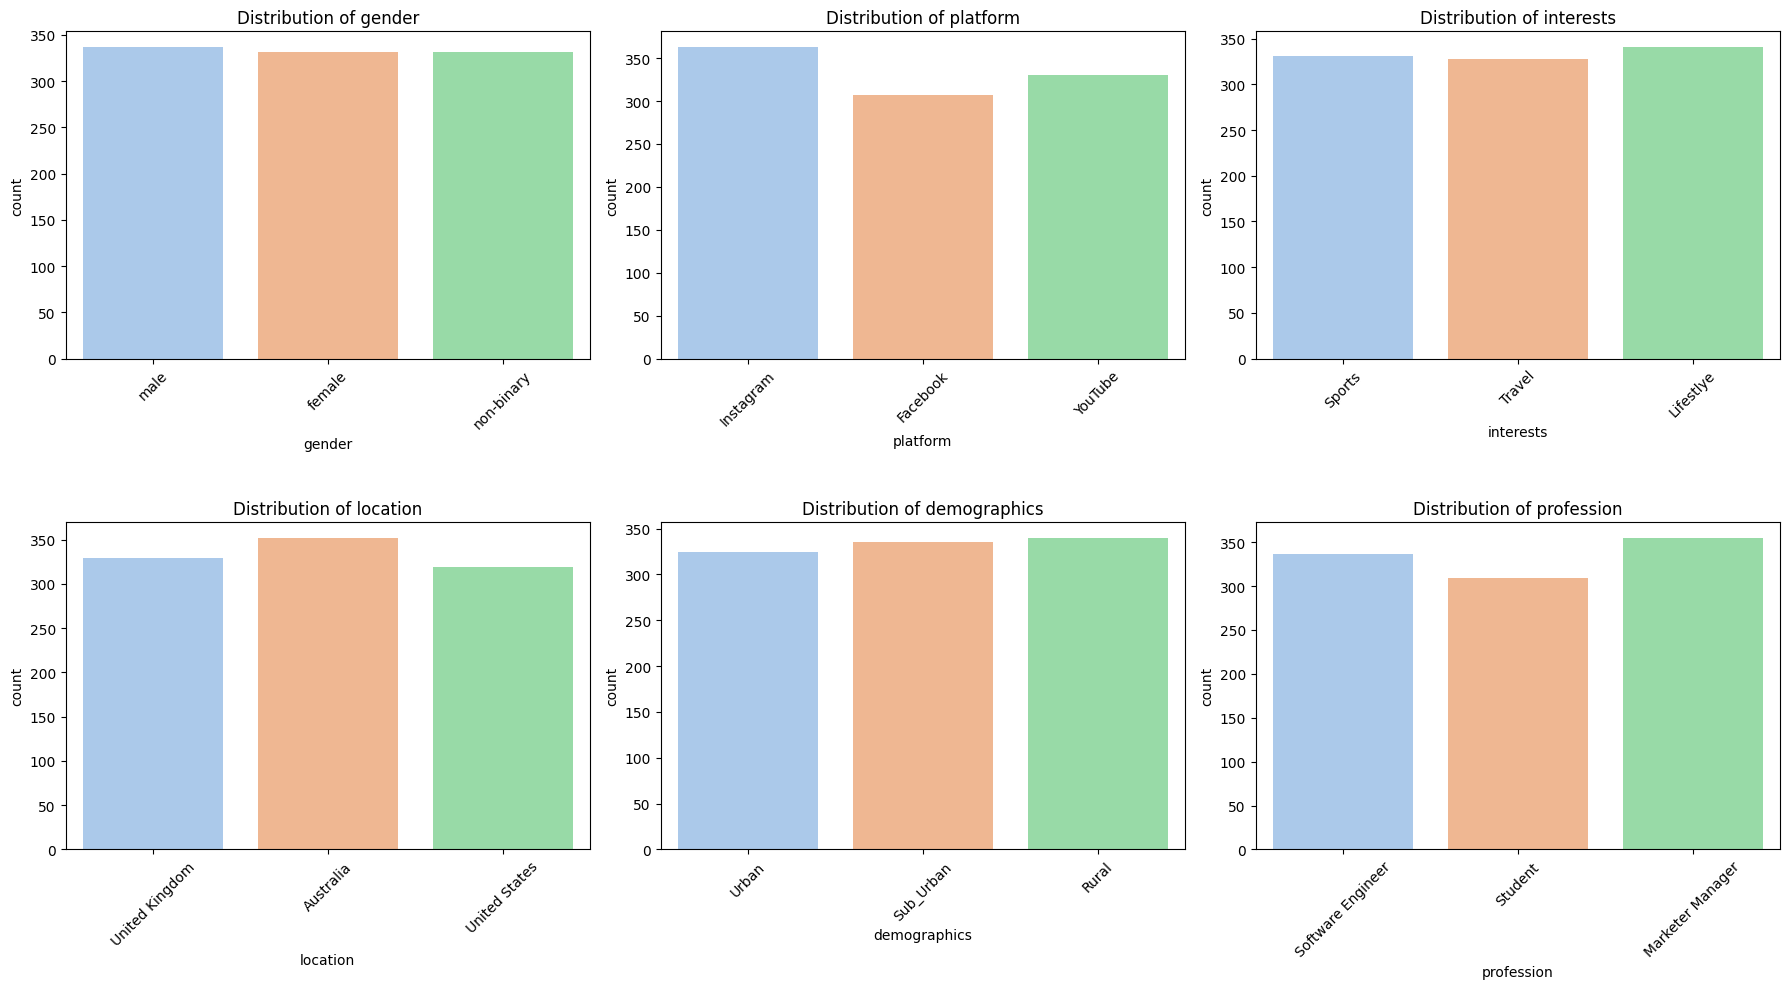

In [91]:
# Analysis of categorical attributes

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

axes = axes.flatten()

i = 0
for attribute in df.columns :
    if df[attribute].dtype == object :
        plt.sca(axes[i])
        sns.countplot(data=df, x=attribute, hue=attribute, palette='pastel', legend=False)
        plt.title(f'Distribution of {attribute}')
        plt.xticks(rotation=45) 
        i += 1

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

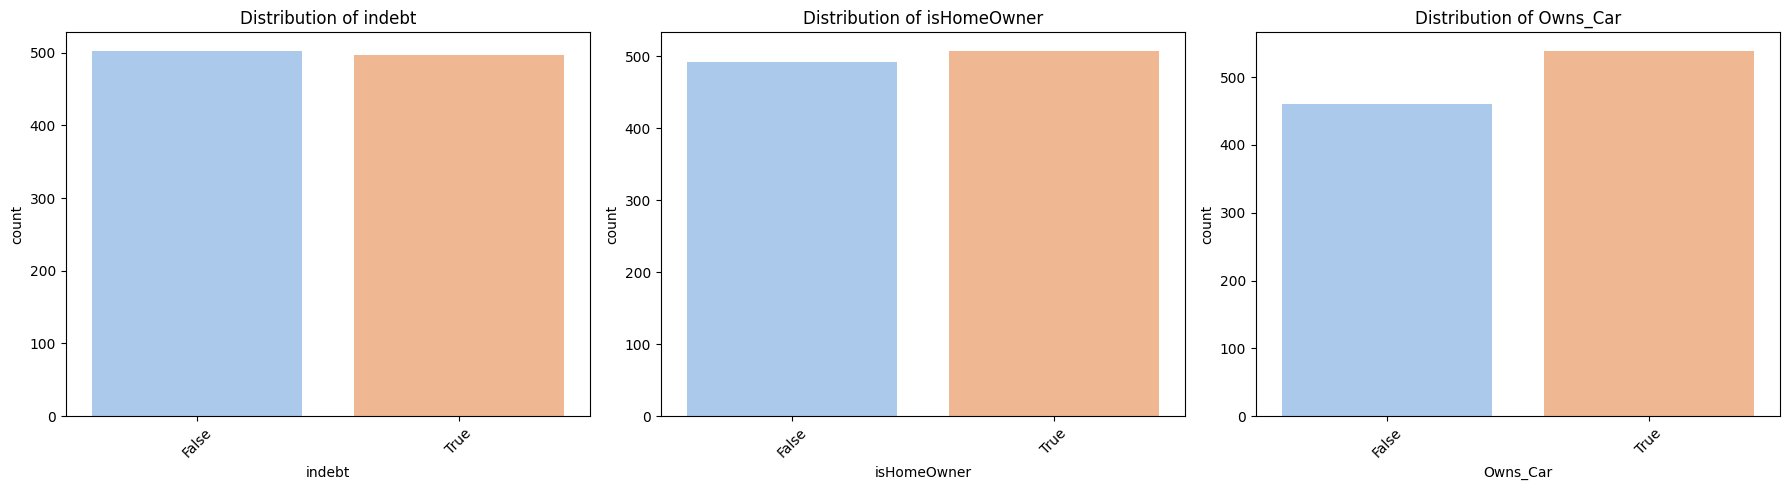

In [92]:
# Analysis of boolan attributes

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

axes = axes.flatten()

i = 0
for attribute in df.columns :
    if df[attribute].dtype == bool :
        plt.sca(axes[i])
        sns.countplot(data=df, x=attribute, hue=attribute, palette='pastel', legend=False)
        plt.title(f'Distribution of {attribute}')
        plt.xticks(rotation=45) 
        i += 1

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

### Observations
We can notice that:
- the _numeric_ labels are quite eterogeneous in `age` but we can identify 3-4 clusters in `income` so that we can discretize the dataset (in order to work better with `numpy`) and the `time_spent` is already quite discrete
- the _categorical_ labels always have 3 labels and they are quite balanced
- the _boolean_ labes are quite balanced too

## Data Cleaning/Processing

In [ ]:
# Create a dictionary to store label encodings
label_encodings = {}

In [ ]:
# Encoding boolean and categorical attributes
le = LabelEncoder()
for attribute in df.columns :
    if str(df[attribute].dtype) != 'int64' :
        df[attribute] = le.fit_transform(df[attribute])
        
        # Store the label encoding in the dictionary
        label_encodings[attribute] = dict(zip(le.classes_, le.transform(le.classes_)))

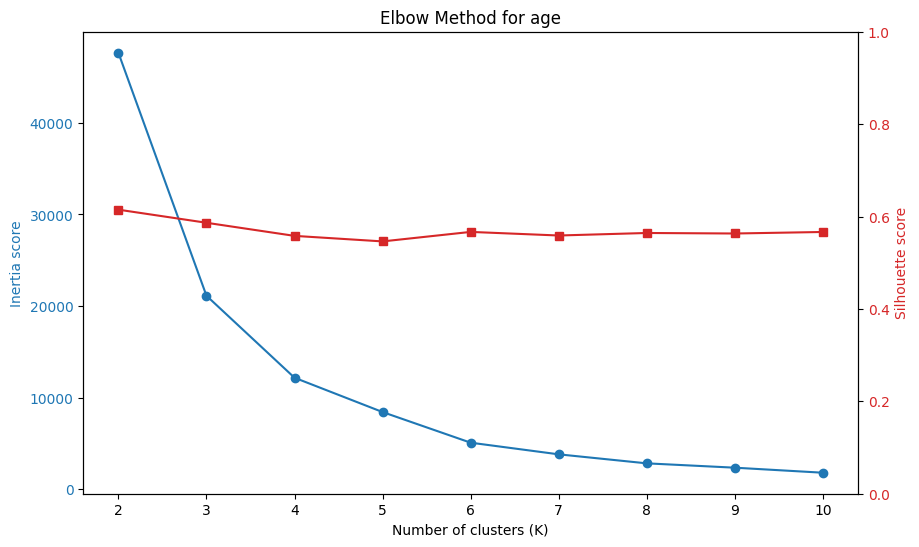

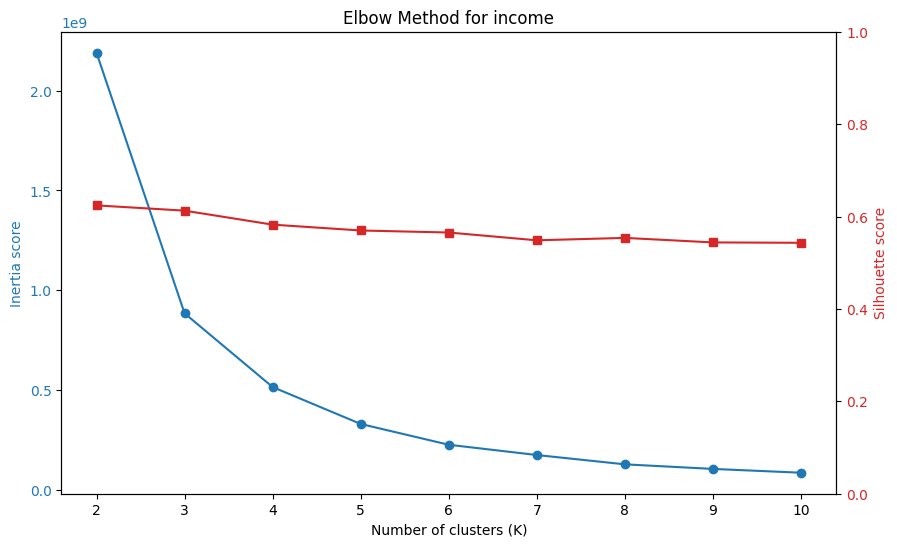

In [ ]:
# Encoding numeric attributes (time_spent is already discreti)
find_clusters(df, 'age')
find_clusters(df, 'income')

There seems to be 3 clusters in `age` and in `income`

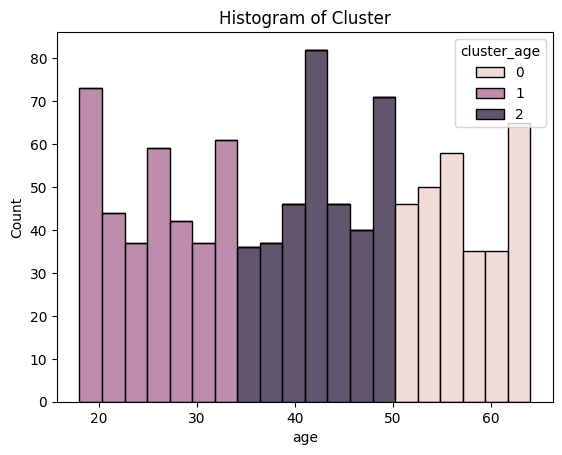

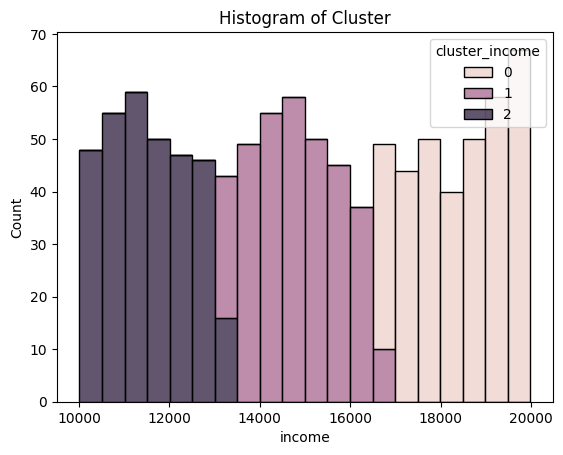

In [ ]:
plot_distribution_cluster(df, 'age', 3)
plot_distribution_cluster(df, 'income', 3)

In [ ]:
# Visually write down dict for clusters
label_encodings['income'] = {
    'income < 13.000' : 0,
    '13.000 >= income >= 17.000' : 1,
    'income > 17.000' : 2
}

label_encodings['age'] = {
    'age < 35' : 0,
    '35 >= income >= 50' : 1,
    'income > 50' : 2
}

In [ ]:
# Drop old labels andr reoreder them
df.drop(['age', 'income'], axis=1, inplace=True)
column_order = ['cluster_age', 'gender', 'time_spent', 'platform', 'interests', 'location', 'demographics', 'profession', 'cluster_income', 'indebt', 'isHomeOwner', 'Owns_Car']
df = df[column_order]

In [ ]:
df.head()

,cluster_age,gender,time_spent,platform,interests,location,demographics,profession,cluster_income,indebt,isHomeOwner,Owns_Car
0,0,1,3,1,1,1,2,1,0,1,0,0
1,2,0,2,0,2,1,2,2,2,1,1,1
2,1,1,8,1,1,0,1,0,1,0,0,0
3,0,2,5,1,2,1,2,2,2,0,1,0
4,1,1,1,1,0,0,2,1,1,0,1,1


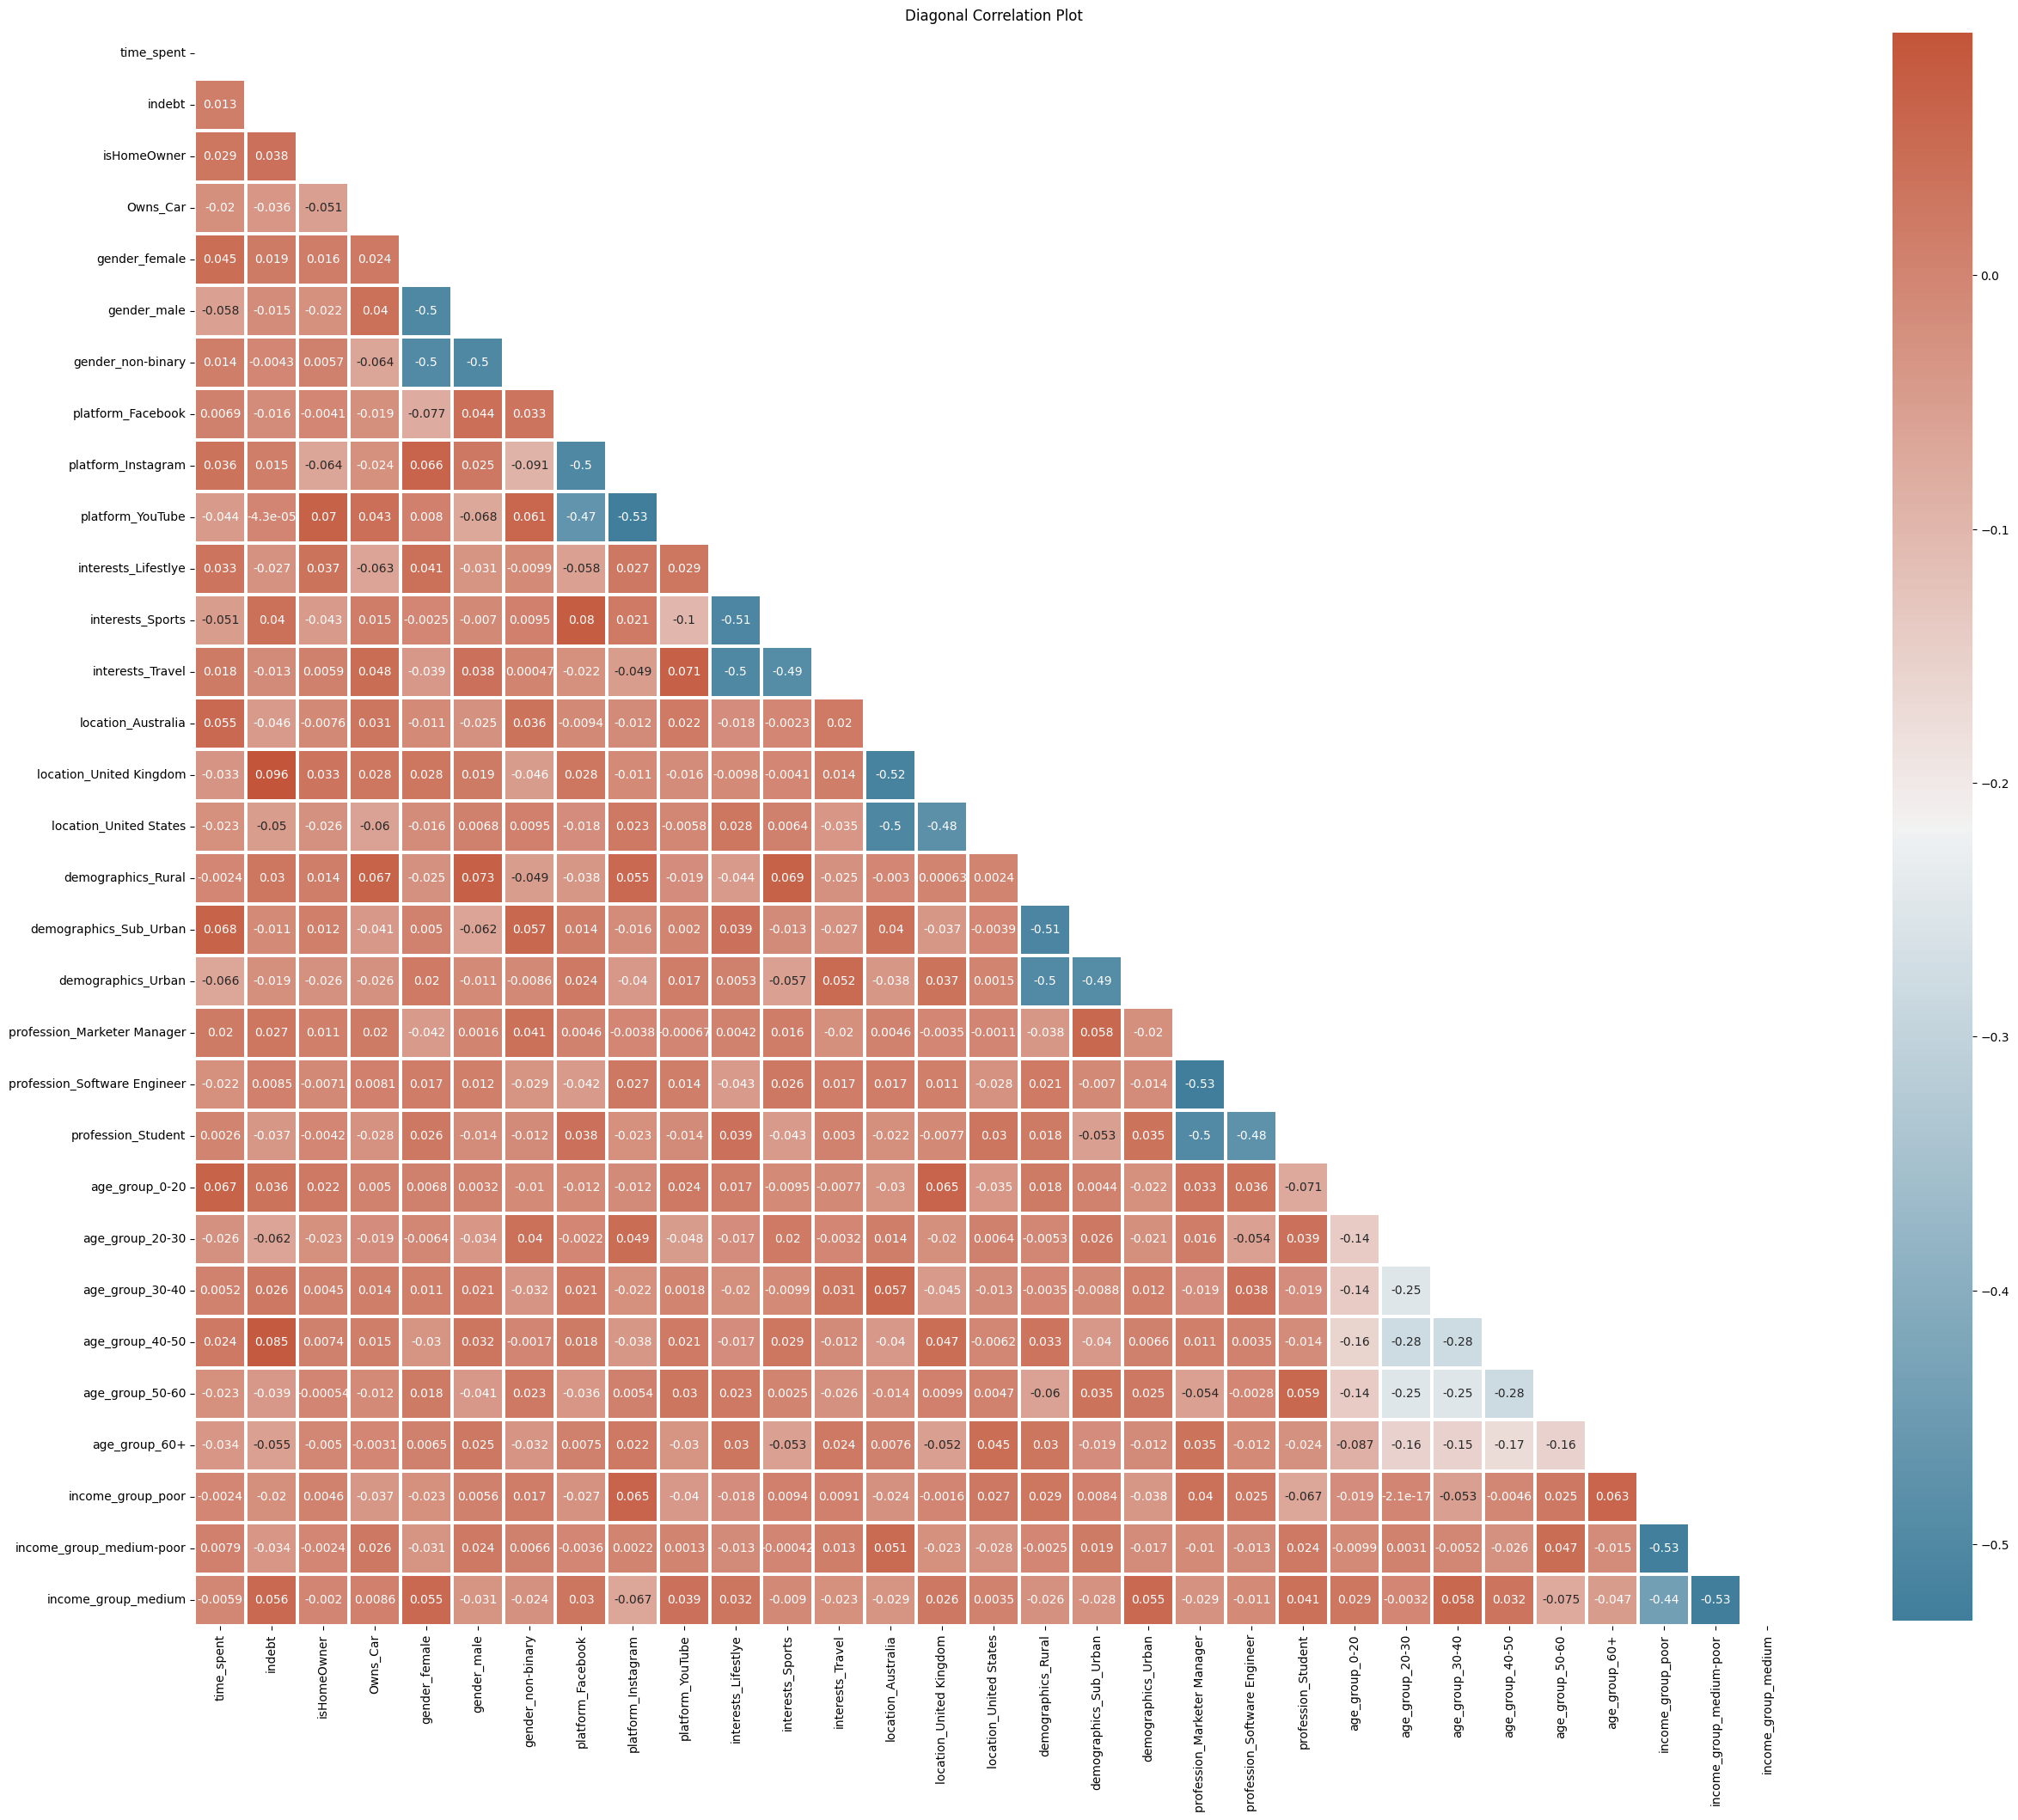

In [96]:
# Plot the correlation matrix 
plt.figure(figsize=(30,30))
corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.title('Diagonal Correlation Plot')
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            cmap=sns.diverging_palette(230, 20, as_cmap=True),   
            square = True,                                 
            linewidths = 1.5,
            cbar_kws = {"shrink": .8});

We can notice that all the attributes are quite uncorrelated

In [ ]:
# We save the dataset in order to be used by the Bayesian Network
df.to_csv('./Datasets/social.csv', index=False)

In [ ]:
# We save the dictionary in order to be used for queries in the Bayesian Network
with open('label_encodings.pkl', 'wb') as pickle_file:
    pickle.dump(label_encodings, pickle_file)